In [1]:
import tensorflow as tf
import scipy.sparse as sp
from scipy.sparse import load_npz, save_npz
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, average_precision_score
import time
import netgan
import sys
sys.path.insert(0, '../src/')
import utils

/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hheidrich/miniconda3/envs/ne

#### Load the data

In [2]:
_A_obs = load_npz('../data/datasets/citeseer.npz')
_N = _A_obs.shape[0]

In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Separate the edges into train, test, validation

In [4]:
train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

In [5]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [6]:
def save_netgan_logs(log_dict, path, num_edges):
    
    overlaps = {i+1:overlap for i, overlap in enumerate(np.array(log_dict['edge_overlaps'])/num_edges)}
    timings = {i+1: timing for i, timing in enumerate(log_dict['times'])}
    
    val_perfs = np.array(log_dict['val_performances'])
    roc_aucs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,0])}
    avg_precs = {i+1: roc_auc for i, roc_auc in enumerate(val_perfs[:,1])}
    
    dcts = {'overlap': overlaps,
            'timing': timings,
            'ROC-AUC': roc_aucs,
            'avg_prec': avg_precs,}
    
    str_len = len(str(len(log_dict['generated_graphs'])))
    Path(path).mkdir(parents=True, exist_ok=True)
    for name, dct in dcts.items():
        utils.save_dict(dct, os.path.join(path, f'{name}.pickle'))
    for i, graph in enumerate(log_dict['generated_graphs']):
        save_npz(matrix=sp.csr_matrix(graph), file=os.path.join(path, f'graph_{i+1:0{str_len}d}'))

In [7]:
def run_multiple_netgan_experiments(num_experiments,
                                    log_path,
                                    train_graph,
                                    val_ones,
                                    val_zeros,
                                    max_iters=200000,
                                    eval_every=2000,
                                    plot_every=2000,
                                    rw_len=16,
                                    batch_size=128):
    str_len = len(str(num_experiments-1))
    walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)
    for i in range(num_experiments):
        # create model
        model = NetGAN(train_graph.shape[0], rw_len, walk_generator=walker.walk, gpu_id=0, use_gumbel=True,
                       disc_iters=3, W_down_discriminator_size=128, W_down_generator_size=128,
                       l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5, generator_layers=[40],
                       discriminator_layers=[30], temp_start=5, learning_rate=0.0003)
        # train model
        log_dict = model.train(A_orig=train_graph, val_ones=val_ones, val_zeros=val_zeros, stopping=1.0,
                               eval_every=eval_every, plot_every=plot_every, max_patience=20,
                               max_iters=max_iters)
        
        # save logs
        save_netgan_logs(log_dict=log_dict,
                         path=os.path.join(log_path, f'Experiment_{i:0{str_len}d}/sampled_graphs/'),
                         num_edges=train_graph.sum())
        
        # close session
        model.session.close()
        # reset graph
        tf.reset_default_graph()




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`,


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
**** Using EO criterion of 1.0 for early stopping
**** Saving snapshots into ../snapshots/model_best_7.ckpt ****
**** Initializing... ****
**** Done.           ****



**** Starting training. ****


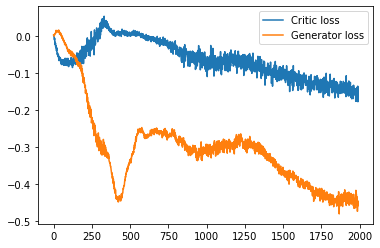

**** Iter 2000   Val ROC 0.825, AP: 0.826, EO 0.013 ****
2500   /200000   training iterations, took 281 seconds so far...


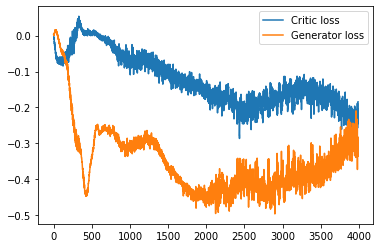

**** Iter 4000   Val ROC 0.891, AP: 0.887, EO 0.033 ****
5000   /200000   training iterations, took 557 seconds so far...


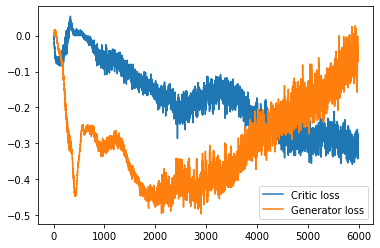

**** Iter 6000   Val ROC 0.912, AP: 0.912, EO 0.058 ****
7500   /200000   training iterations, took 833 seconds so far...


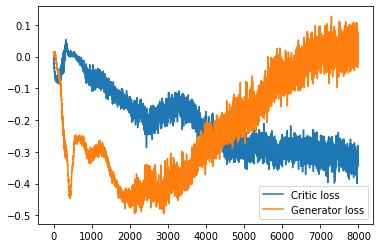

**** Iter 8000   Val ROC 0.923, AP: 0.927, EO 0.076 ****


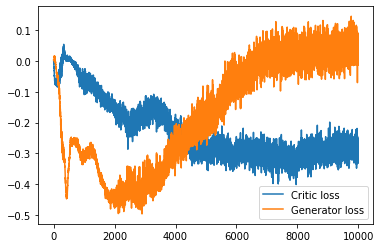

10000  /200000   training iterations, took 1109 seconds so far...
**** Iter 10000  Val ROC 0.925, AP: 0.932, EO 0.096 ****


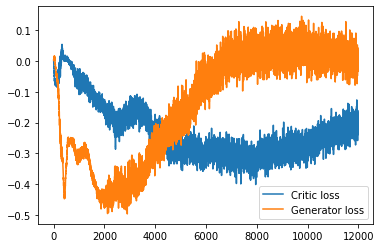

**** Iter 12000  Val ROC 0.929, AP: 0.933, EO 0.142 ****
12500  /200000   training iterations, took 1421 seconds so far...


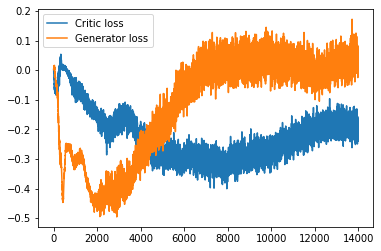

**** Iter 14000  Val ROC 0.930, AP: 0.937, EO 0.181 ****
15000  /200000   training iterations, took 1697 seconds so far...


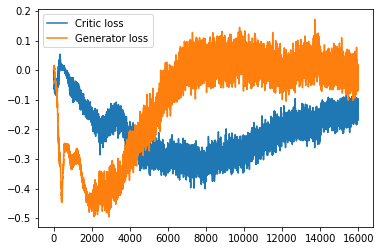

**** Iter 16000  Val ROC 0.932, AP: 0.939, EO 0.208 ****
17500  /200000   training iterations, took 1972 seconds so far...


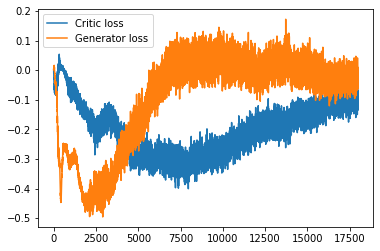

**** Iter 18000  Val ROC 0.929, AP: 0.936, EO 0.232 ****


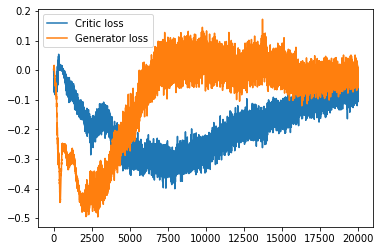

20000  /200000   training iterations, took 2248 seconds so far...
**** Iter 20000  Val ROC 0.933, AP: 0.939, EO 0.264 ****


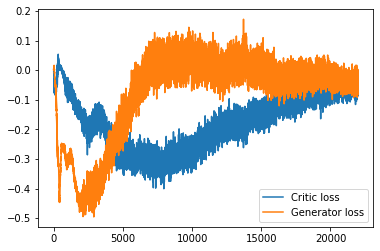

**** Iter 22000  Val ROC 0.933, AP: 0.938, EO 0.292 ****
22500  /200000   training iterations, took 2561 seconds so far...


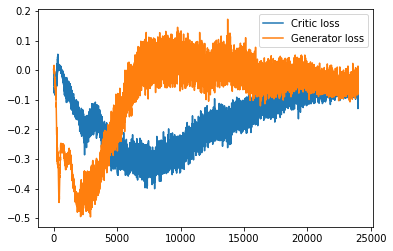

**** Iter 24000  Val ROC 0.931, AP: 0.933, EO 0.316 ****
25000  /200000   training iterations, took 2836 seconds so far...


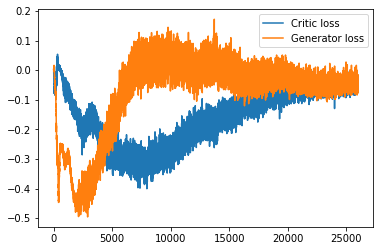

**** Iter 26000  Val ROC 0.933, AP: 0.935, EO 0.347 ****
27500  /200000   training iterations, took 3112 seconds so far...


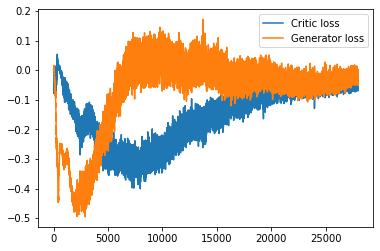

**** Iter 28000  Val ROC 0.935, AP: 0.935, EO 0.373 ****


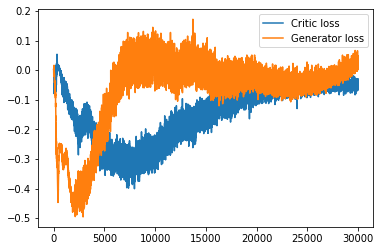

30000  /200000   training iterations, took 3387 seconds so far...
**** Iter 30000  Val ROC 0.932, AP: 0.935, EO 0.396 ****


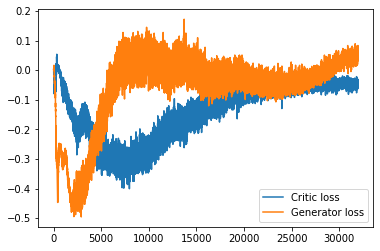

**** Iter 32000  Val ROC 0.930, AP: 0.931, EO 0.413 ****
32500  /200000   training iterations, took 3700 seconds so far...


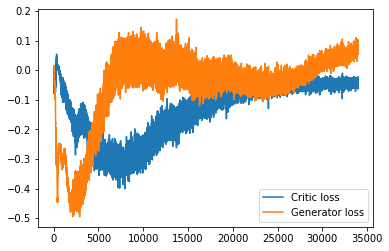

**** Iter 34000  Val ROC 0.932, AP: 0.931, EO 0.439 ****
35000  /200000   training iterations, took 3975 seconds so far...


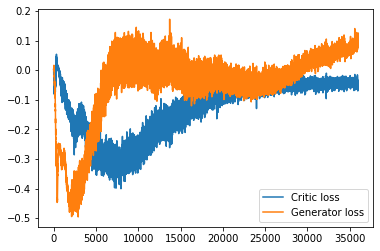

**** Iter 36000  Val ROC 0.931, AP: 0.934, EO 0.451 ****
37500  /200000   training iterations, took 4251 seconds so far...


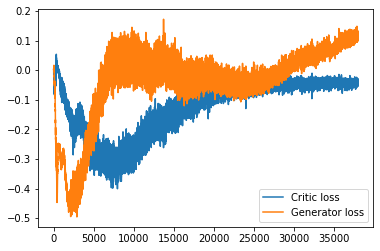

**** Iter 38000  Val ROC 0.930, AP: 0.929, EO 0.475 ****


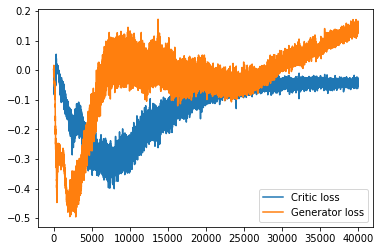

40000  /200000   training iterations, took 4527 seconds so far...
**** Iter 40000  Val ROC 0.926, AP: 0.925, EO 0.499 ****


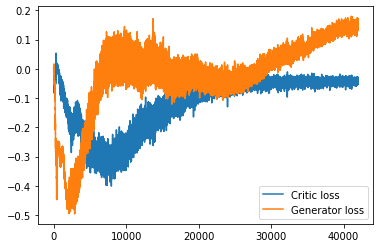

**** Iter 42000  Val ROC 0.930, AP: 0.932, EO 0.503 ****
42500  /200000   training iterations, took 4839 seconds so far...


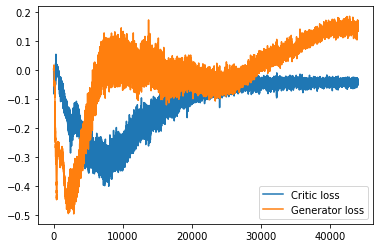

**** Iter 44000  Val ROC 0.923, AP: 0.921, EO 0.512 ****
45000  /200000   training iterations, took 5114 seconds so far...


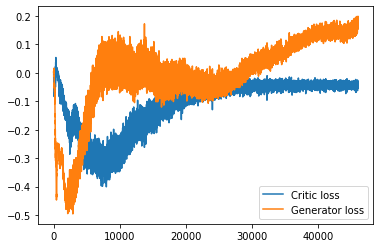

**** Iter 46000  Val ROC 0.926, AP: 0.923, EO 0.519 ****
47500  /200000   training iterations, took 5389 seconds so far...


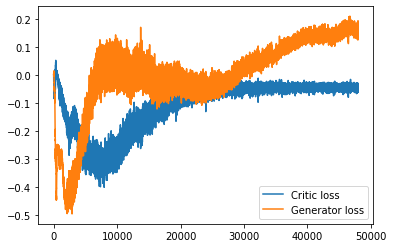

**** Iter 48000  Val ROC 0.925, AP: 0.927, EO 0.526 ****


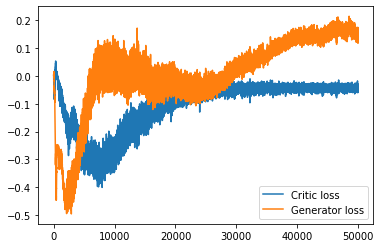

50000  /200000   training iterations, took 5665 seconds so far...
**** Iter 50000  Val ROC 0.922, AP: 0.924, EO 0.538 ****


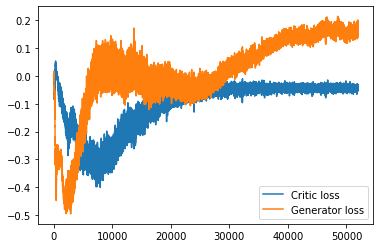

**** Iter 52000  Val ROC 0.920, AP: 0.924, EO 0.532 ****
52500  /200000   training iterations, took 5978 seconds so far...


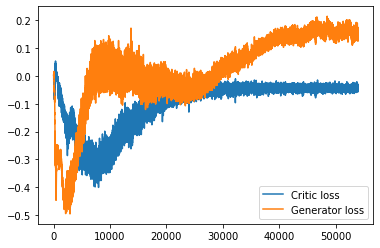

**** Iter 54000  Val ROC 0.920, AP: 0.923, EO 0.549 ****
55000  /200000   training iterations, took 6253 seconds so far...


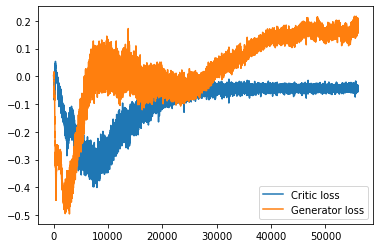

**** Iter 56000  Val ROC 0.924, AP: 0.926, EO 0.545 ****
57500  /200000   training iterations, took 6529 seconds so far...


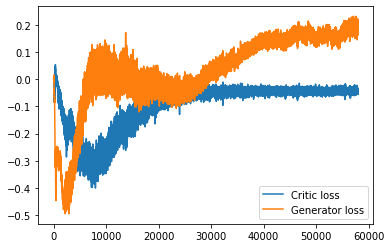

**** Iter 58000  Val ROC 0.922, AP: 0.924, EO 0.558 ****


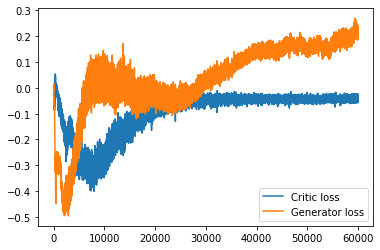

60000  /200000   training iterations, took 6805 seconds so far...
**** Iter 60000  Val ROC 0.925, AP: 0.925, EO 0.549 ****


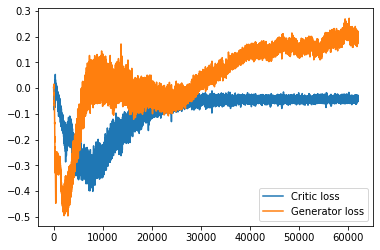

**** Iter 62000  Val ROC 0.921, AP: 0.923, EO 0.559 ****
62500  /200000   training iterations, took 7118 seconds so far...


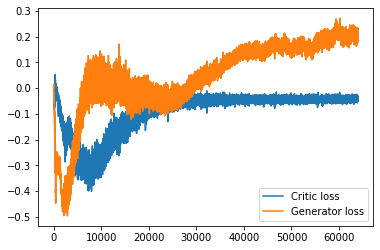

**** Iter 64000  Val ROC 0.922, AP: 0.924, EO 0.572 ****
65000  /200000   training iterations, took 7394 seconds so far...


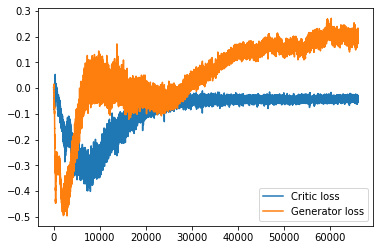

**** Iter 66000  Val ROC 0.919, AP: 0.918, EO 0.572 ****
67500  /200000   training iterations, took 7669 seconds so far...


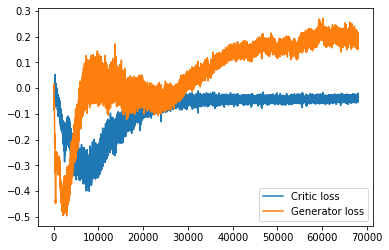

**** Iter 68000  Val ROC 0.912, AP: 0.915, EO 0.577 ****


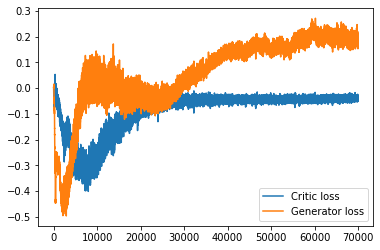

70000  /200000   training iterations, took 7946 seconds so far...
**** Iter 70000  Val ROC 0.923, AP: 0.924, EO 0.585 ****


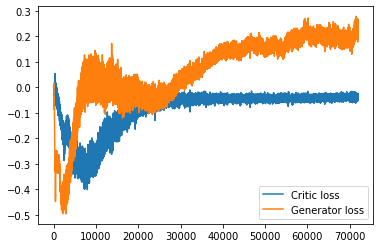

**** Iter 72000  Val ROC 0.919, AP: 0.923, EO 0.595 ****
72500  /200000   training iterations, took 8258 seconds so far...


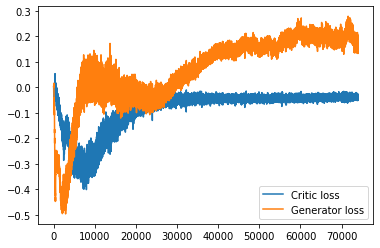

**** Iter 74000  Val ROC 0.916, AP: 0.919, EO 0.592 ****
75000  /200000   training iterations, took 8533 seconds so far...


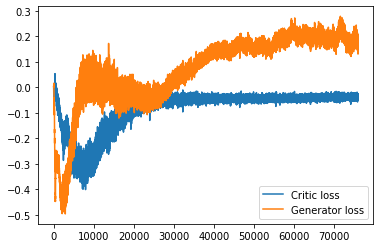

**** Iter 76000  Val ROC 0.918, AP: 0.921, EO 0.595 ****
77500  /200000   training iterations, took 8809 seconds so far...


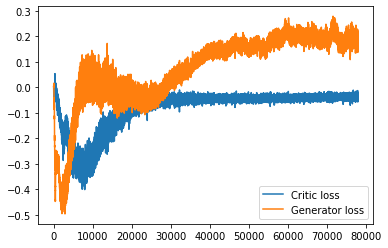

**** Iter 78000  Val ROC 0.917, AP: 0.919, EO 0.591 ****


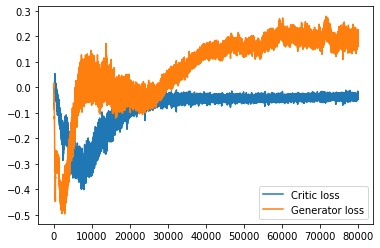

80000  /200000   training iterations, took 9085 seconds so far...
**** Iter 80000  Val ROC 0.918, AP: 0.919, EO 0.600 ****


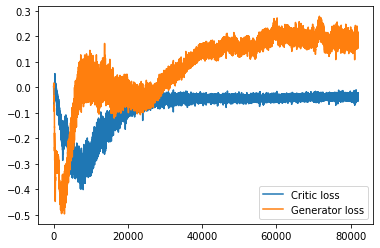

**** Iter 82000  Val ROC 0.915, AP: 0.918, EO 0.608 ****
82500  /200000   training iterations, took 9397 seconds so far...


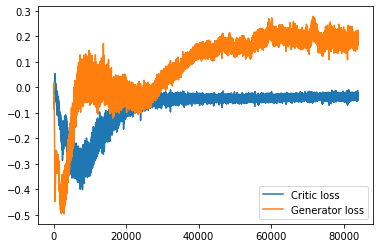

**** Iter 84000  Val ROC 0.911, AP: 0.915, EO 0.613 ****
85000  /200000   training iterations, took 9673 seconds so far...


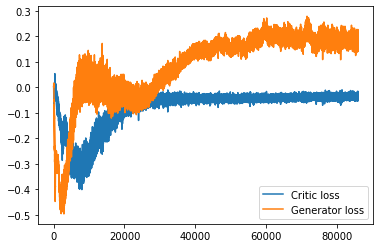

**** Iter 86000  Val ROC 0.913, AP: 0.917, EO 0.610 ****
87500  /200000   training iterations, took 9948 seconds so far...


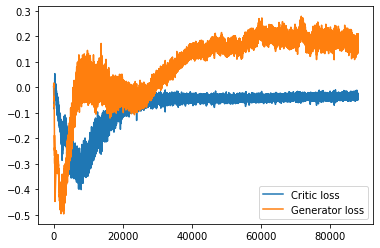

**** Iter 88000  Val ROC 0.913, AP: 0.916, EO 0.612 ****


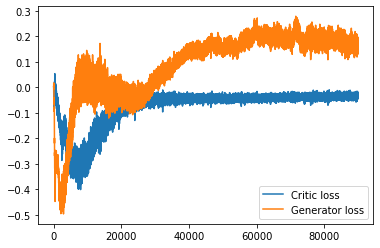

90000  /200000   training iterations, took 10224 seconds so far...
**** Iter 90000  Val ROC 0.906, AP: 0.909, EO 0.613 ****


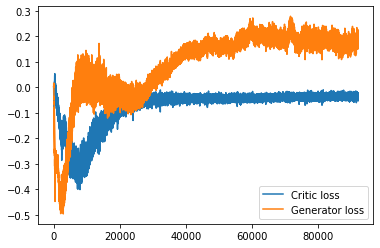

**** Iter 92000  Val ROC 0.916, AP: 0.918, EO 0.616 ****
92500  /200000   training iterations, took 10536 seconds so far...


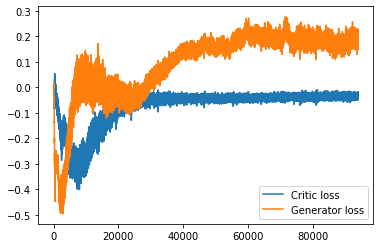

**** Iter 94000  Val ROC 0.917, AP: 0.918, EO 0.614 ****
95000  /200000   training iterations, took 10812 seconds so far...


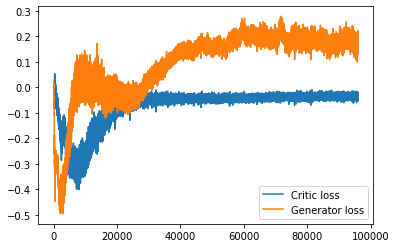

**** Iter 96000  Val ROC 0.919, AP: 0.919, EO 0.628 ****
97500  /200000   training iterations, took 11088 seconds so far...


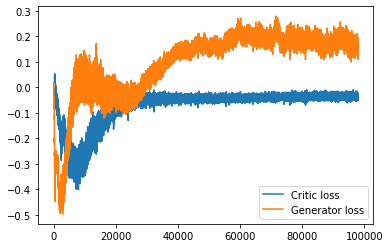

**** Iter 98000  Val ROC 0.911, AP: 0.914, EO 0.617 ****


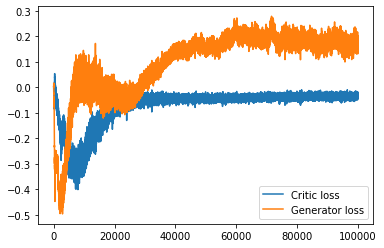

100000 /200000   training iterations, took 11364 seconds so far...
**** Iter 100000 Val ROC 0.912, AP: 0.916, EO 0.630 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


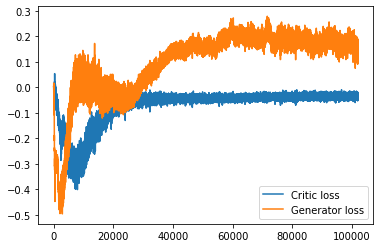

**** Iter 102000 Val ROC 0.908, AP: 0.911, EO 0.636 ****
102500 /200000   training iterations, took 11677 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


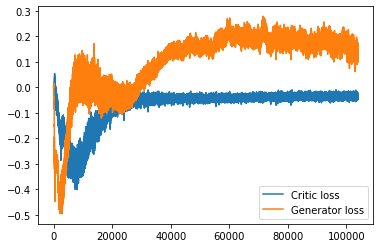

**** Iter 104000 Val ROC 0.915, AP: 0.917, EO 0.639 ****
105000 /200000   training iterations, took 11953 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


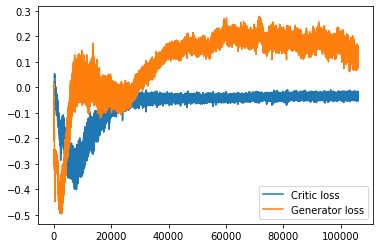

**** Iter 106000 Val ROC 0.915, AP: 0.917, EO 0.639 ****
107500 /200000   training iterations, took 12228 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


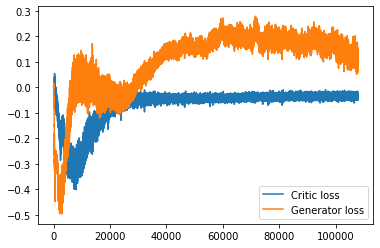

**** Iter 108000 Val ROC 0.913, AP: 0.916, EO 0.643 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


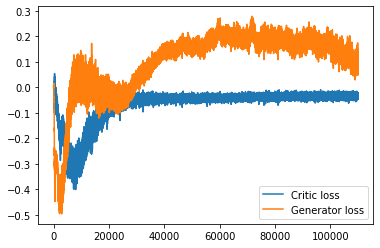

110000 /200000   training iterations, took 12504 seconds so far...
**** Iter 110000 Val ROC 0.915, AP: 0.917, EO 0.644 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


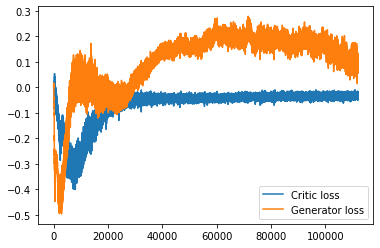

**** Iter 112000 Val ROC 0.916, AP: 0.917, EO 0.639 ****
112500 /200000   training iterations, took 12817 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


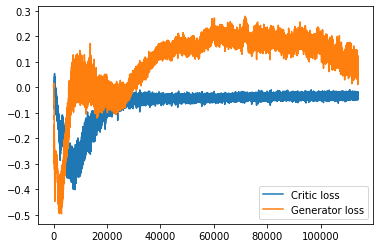

**** Iter 114000 Val ROC 0.917, AP: 0.918, EO 0.648 ****
115000 /200000   training iterations, took 13092 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


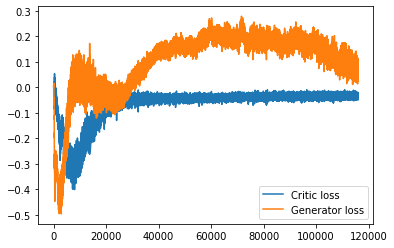

**** Iter 116000 Val ROC 0.913, AP: 0.915, EO 0.648 ****
117500 /200000   training iterations, took 13368 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


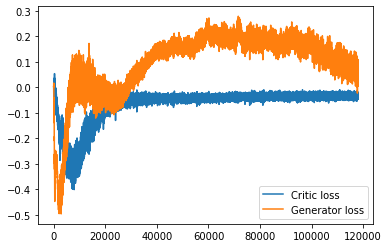

**** Iter 118000 Val ROC 0.914, AP: 0.916, EO 0.654 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


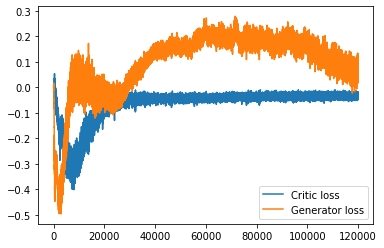

120000 /200000   training iterations, took 13644 seconds so far...
**** Iter 120000 Val ROC 0.915, AP: 0.916, EO 0.651 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


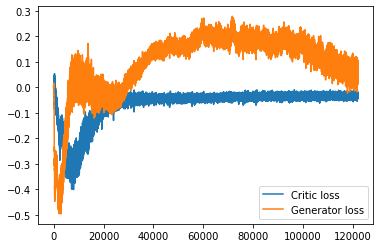

**** Iter 122000 Val ROC 0.915, AP: 0.916, EO 0.649 ****
122500 /200000   training iterations, took 13957 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


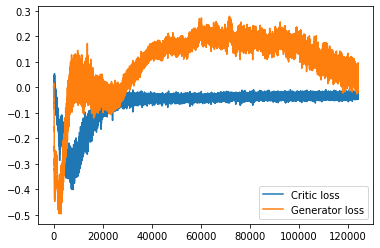

**** Iter 124000 Val ROC 0.910, AP: 0.911, EO 0.649 ****
125000 /200000   training iterations, took 14232 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


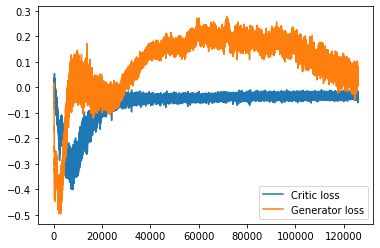

**** Iter 126000 Val ROC 0.909, AP: 0.910, EO 0.658 ****
127500 /200000   training iterations, took 14508 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


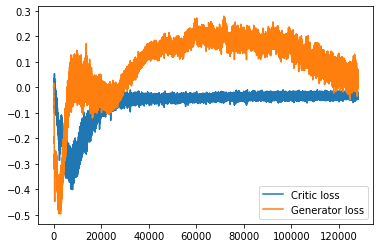

**** Iter 128000 Val ROC 0.910, AP: 0.911, EO 0.660 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


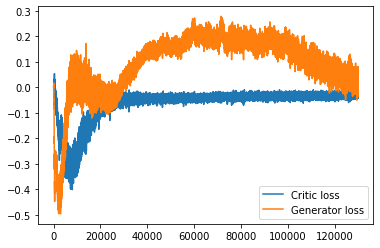

130000 /200000   training iterations, took 14784 seconds so far...
**** Iter 130000 Val ROC 0.912, AP: 0.914, EO 0.672 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


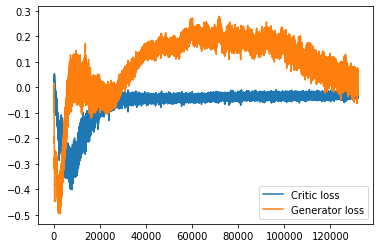

**** Iter 132000 Val ROC 0.909, AP: 0.913, EO 0.661 ****
132500 /200000   training iterations, took 15107 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


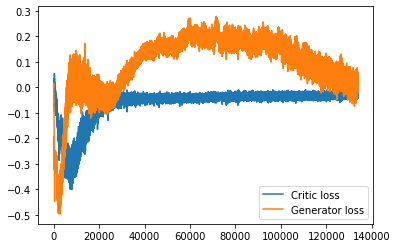

**** Iter 134000 Val ROC 0.906, AP: 0.910, EO 0.669 ****
135000 /200000   training iterations, took 15403 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


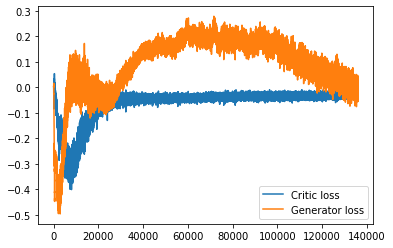

**** Iter 136000 Val ROC 0.910, AP: 0.913, EO 0.667 ****
137500 /200000   training iterations, took 15698 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


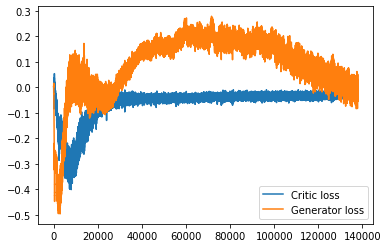

**** Iter 138000 Val ROC 0.909, AP: 0.914, EO 0.662 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


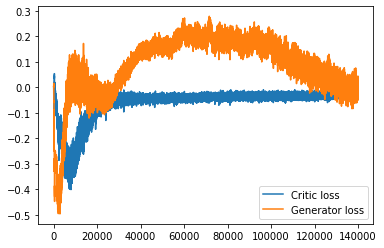

140000 /200000   training iterations, took 15989 seconds so far...
**** Iter 140000 Val ROC 0.906, AP: 0.909, EO 0.673 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


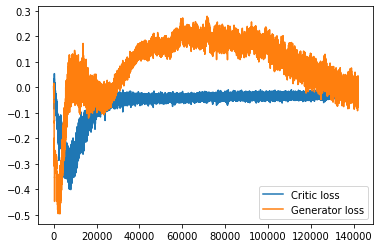

**** Iter 142000 Val ROC 0.912, AP: 0.914, EO 0.674 ****
142500 /200000   training iterations, took 16312 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


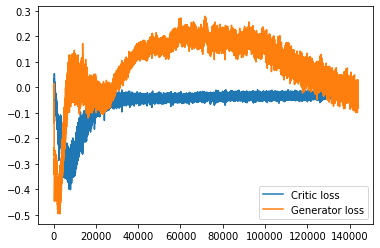

**** Iter 144000 Val ROC 0.908, AP: 0.910, EO 0.677 ****
145000 /200000   training iterations, took 16604 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


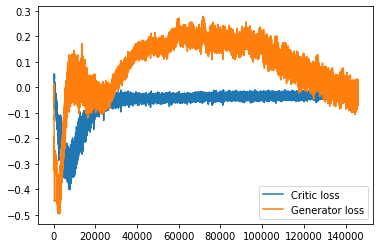

**** Iter 146000 Val ROC 0.908, AP: 0.912, EO 0.675 ****
147500 /200000   training iterations, took 16881 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


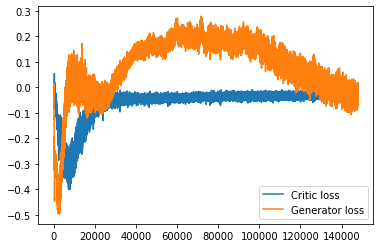

**** Iter 148000 Val ROC 0.909, AP: 0.911, EO 0.676 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


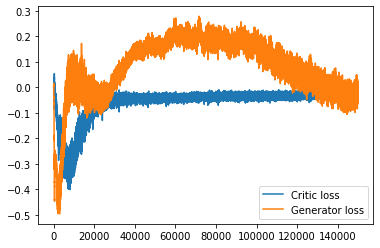

150000 /200000   training iterations, took 17157 seconds so far...
**** Iter 150000 Val ROC 0.909, AP: 0.912, EO 0.662 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


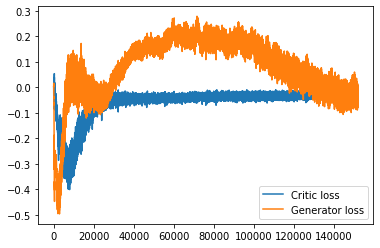

**** Iter 152000 Val ROC 0.906, AP: 0.910, EO 0.676 ****
152500 /200000   training iterations, took 17469 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


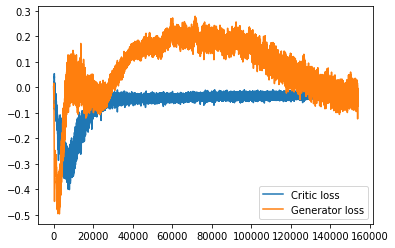

**** Iter 154000 Val ROC 0.903, AP: 0.906, EO 0.682 ****
155000 /200000   training iterations, took 17745 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


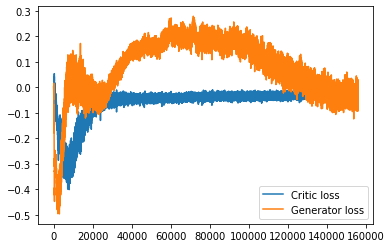

**** Iter 156000 Val ROC 0.908, AP: 0.911, EO 0.677 ****
157500 /200000   training iterations, took 18021 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


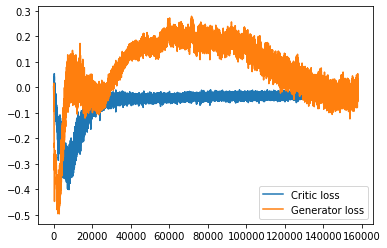

**** Iter 158000 Val ROC 0.910, AP: 0.913, EO 0.683 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


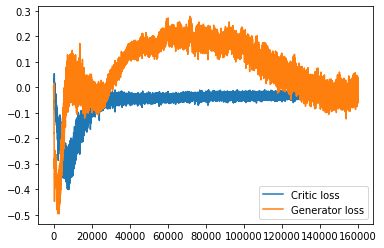

160000 /200000   training iterations, took 18298 seconds so far...
**** Iter 160000 Val ROC 0.909, AP: 0.912, EO 0.685 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


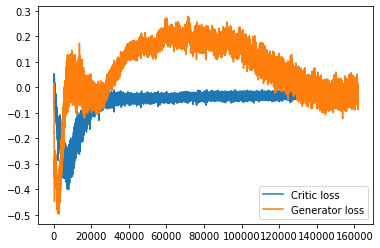

**** Iter 162000 Val ROC 0.907, AP: 0.910, EO 0.683 ****
162500 /200000   training iterations, took 18611 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


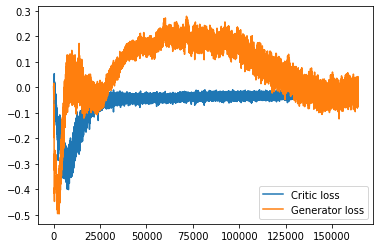

**** Iter 164000 Val ROC 0.906, AP: 0.910, EO 0.683 ****
165000 /200000   training iterations, took 18887 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


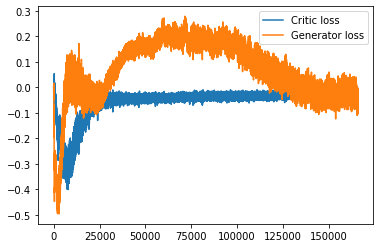

**** Iter 166000 Val ROC 0.904, AP: 0.907, EO 0.689 ****
167500 /200000   training iterations, took 19163 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


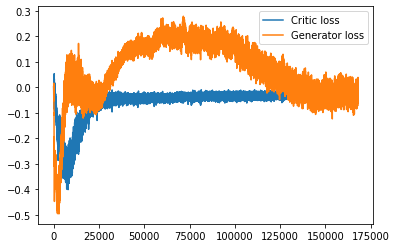

**** Iter 168000 Val ROC 0.907, AP: 0.910, EO 0.685 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


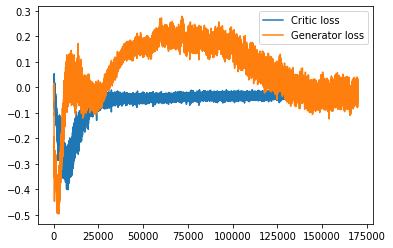

170000 /200000   training iterations, took 19440 seconds so far...
**** Iter 170000 Val ROC 0.908, AP: 0.911, EO 0.689 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


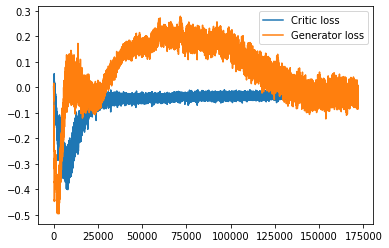

**** Iter 172000 Val ROC 0.910, AP: 0.913, EO 0.687 ****
172500 /200000   training iterations, took 19752 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


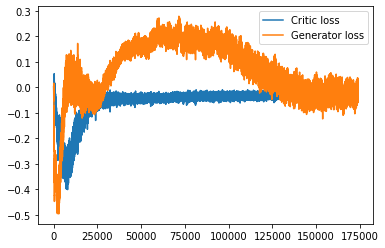

**** Iter 174000 Val ROC 0.908, AP: 0.911, EO 0.695 ****
175000 /200000   training iterations, took 20028 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


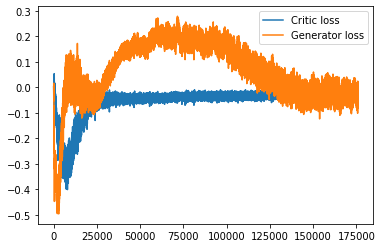

**** Iter 176000 Val ROC 0.907, AP: 0.911, EO 0.689 ****
177500 /200000   training iterations, took 20303 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


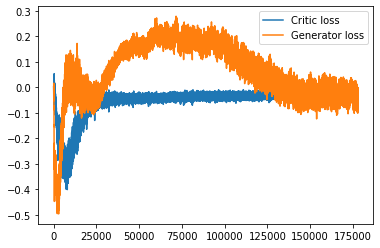

**** Iter 178000 Val ROC 0.910, AP: 0.913, EO 0.688 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


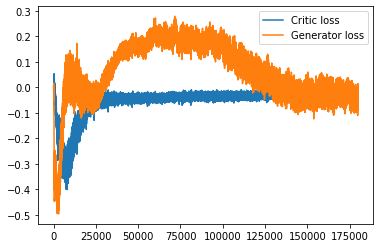

180000 /200000   training iterations, took 20580 seconds so far...
**** Iter 180000 Val ROC 0.905, AP: 0.907, EO 0.688 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


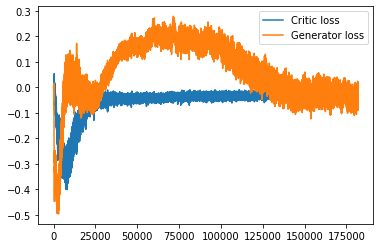

**** Iter 182000 Val ROC 0.906, AP: 0.910, EO 0.692 ****
182500 /200000   training iterations, took 20892 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


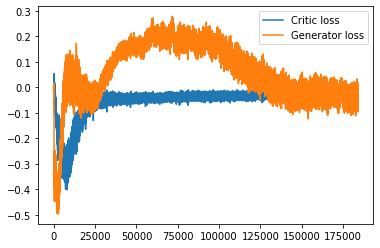

**** Iter 184000 Val ROC 0.900, AP: 0.905, EO 0.696 ****
185000 /200000   training iterations, took 21168 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


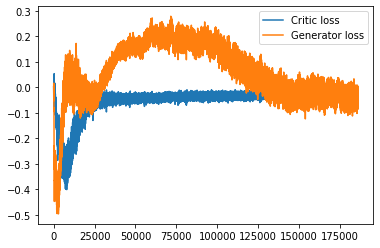

**** Iter 186000 Val ROC 0.904, AP: 0.908, EO 0.696 ****
187500 /200000   training iterations, took 21444 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


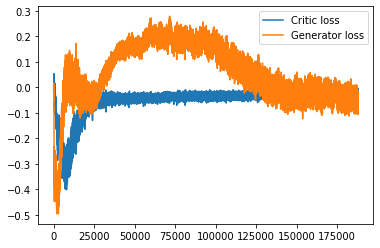

**** Iter 188000 Val ROC 0.900, AP: 0.904, EO 0.685 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


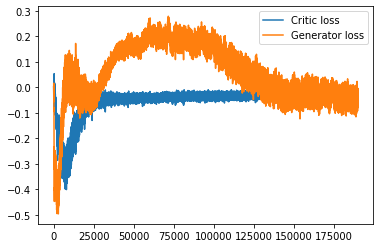

190000 /200000   training iterations, took 21720 seconds so far...
**** Iter 190000 Val ROC 0.914, AP: 0.916, EO 0.688 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


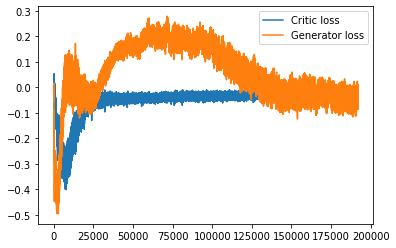

**** Iter 192000 Val ROC 0.908, AP: 0.911, EO 0.688 ****
192500 /200000   training iterations, took 22033 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


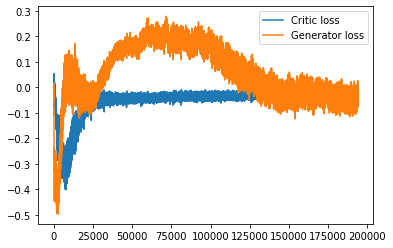

**** Iter 194000 Val ROC 0.900, AP: 0.904, EO 0.703 ****
195000 /200000   training iterations, took 22309 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


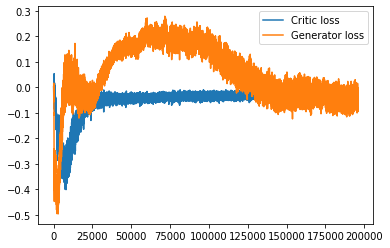

**** Iter 196000 Val ROC 0.903, AP: 0.906, EO 0.700 ****
197500 /200000   training iterations, took 22585 seconds so far...


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


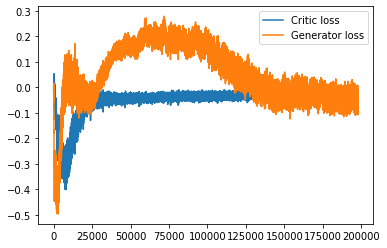

**** Iter 198000 Val ROC 0.905, AP: 0.907, EO 0.700 ****


/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


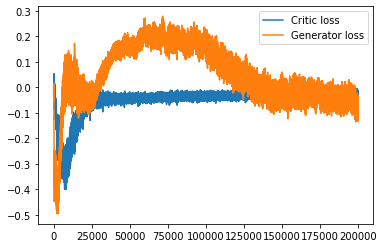

**** Training completed after 199999 iterations. ****


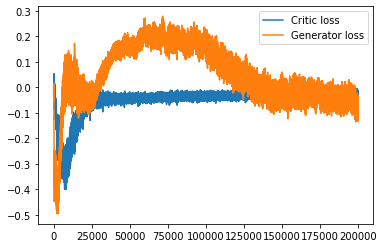

**** Using EO criterion of 1.0 for early stopping
**** Saving snapshots into ../snapshots/model_best_8.ckpt ****
**** Initializing... ****
**** Done.           ****


**** Starting training. ****


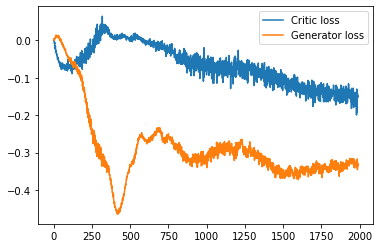

**** Iter 2000   Val ROC 0.825, AP: 0.821, EO 0.010 ****
2500   /200000   training iterations, took 274 seconds so far...


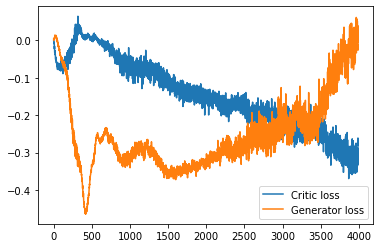

**** Iter 4000   Val ROC 0.898, AP: 0.894, EO 0.033 ****
5000   /200000   training iterations, took 546 seconds so far...


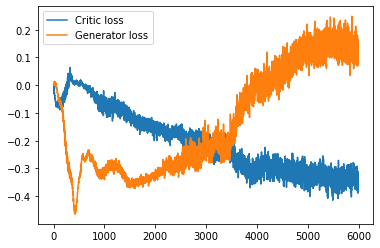

**** Iter 6000   Val ROC 0.909, AP: 0.908, EO 0.052 ****
7500   /200000   training iterations, took 829 seconds so far...


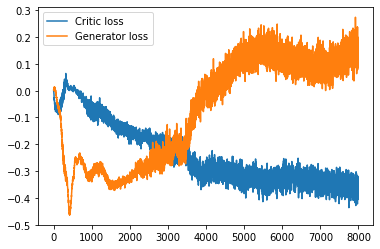

**** Iter 8000   Val ROC 0.921, AP: 0.924, EO 0.071 ****


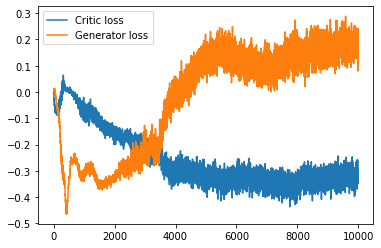

10000  /200000   training iterations, took 1112 seconds so far...
**** Iter 10000  Val ROC 0.919, AP: 0.927, EO 0.097 ****


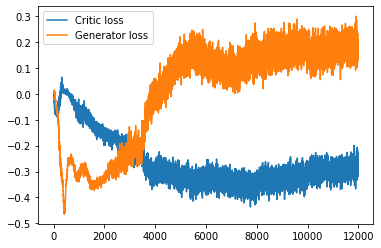

**** Iter 12000  Val ROC 0.928, AP: 0.934, EO 0.140 ****
12500  /200000   training iterations, took 1419 seconds so far...


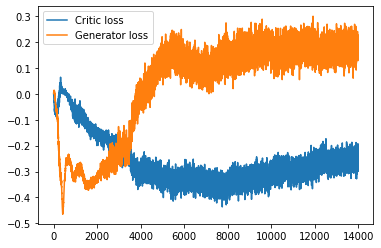

**** Iter 14000  Val ROC 0.933, AP: 0.938, EO 0.169 ****
15000  /200000   training iterations, took 1690 seconds so far...


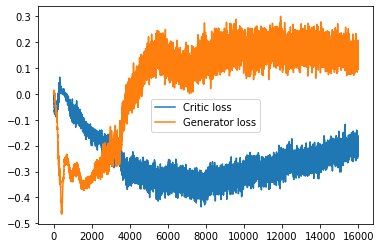

**** Iter 16000  Val ROC 0.939, AP: 0.943, EO 0.194 ****
17500  /200000   training iterations, took 1961 seconds so far...


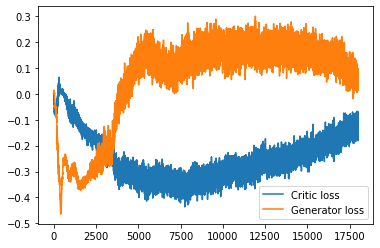

**** Iter 18000  Val ROC 0.936, AP: 0.942, EO 0.222 ****


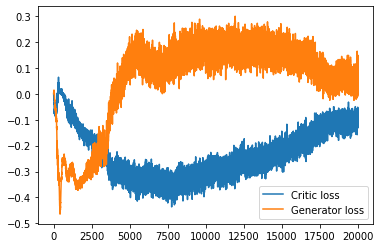

20000  /200000   training iterations, took 2232 seconds so far...
**** Iter 20000  Val ROC 0.932, AP: 0.939, EO 0.250 ****


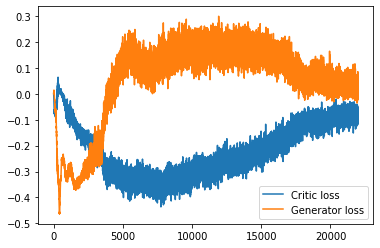

**** Iter 22000  Val ROC 0.937, AP: 0.943, EO 0.268 ****
22500  /200000   training iterations, took 2538 seconds so far...


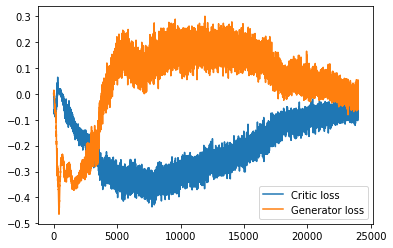

**** Iter 24000  Val ROC 0.932, AP: 0.938, EO 0.299 ****
25000  /200000   training iterations, took 2818 seconds so far...


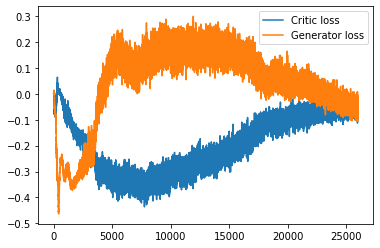

**** Iter 26000  Val ROC 0.930, AP: 0.937, EO 0.324 ****
27500  /200000   training iterations, took 3088 seconds so far...


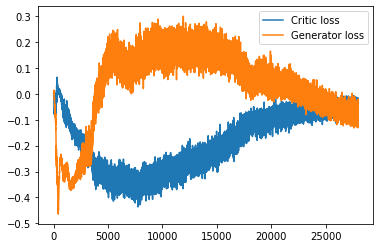

**** Iter 28000  Val ROC 0.928, AP: 0.935, EO 0.340 ****


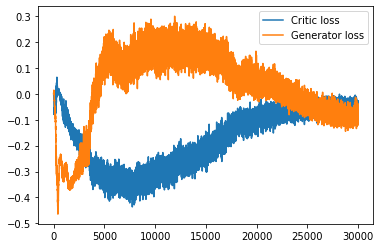

30000  /200000   training iterations, took 3361 seconds so far...
**** Iter 30000  Val ROC 0.933, AP: 0.933, EO 0.369 ****


In [ ]:
run_multiple_netgan_experiments(num_experiments=5,
                                log_path='../logs/citeseer/baseline_NetGan/',
                                train_graph=train_graph,
                                val_ones=val_ones,
                                val_zeros=val_zeros)